In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, create_lags, apply_moving_average_for_roc, split_data_frame, create_sequences, simplify_df, trigonometric_date_encoding

### Preprocessing

In [2]:
df = load_csv('../data/xmr_lunarcrush_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               38656 non-null  int64         
 1   time                    38656 non-null  datetime64[ns]
 2   open                    38656 non-null  float64       
 3   close                   38656 non-null  float64       
 4   high                    38656 non-null  float64       
 5   low                     38656 non-null  float64       
 6   volume_24h              38656 non-null  float64       
 7   circulating_supply      38656 non-null  float64       
 8   day                     38656 non-null  int32         
 9   month                   38656 non-null  int32         
 10  year                    38656 non-null  int32         
 11  Month_Category_Bearish  38656 non-null  float64       
 12  Month_Category_Bullish  38656 non-null  float6

In [4]:
df.head(10)

,timestamp,time,open,close,high,low,volume_24h,circulating_supply,day,month,year,Month_Category_Bearish,Month_Category_Bullish,Month_Category_Normal,ROC_0,ROC_1,ROC_2
0,1567036800,2019-08-29,72.37,67.28,72.46,67.13,68778555.58,17667375.0,29,8,2019,0.0,1.0,0.0,0,0,1
1,1567123200,2019-08-30,66.69,68.75,70.00,66.17,68778555.58,17667375.0,30,8,2019,0.0,1.0,0.0,0,0,1
2,1567209600,2019-08-31,68.65,68.07,69.95,66.76,68778555.58,17667375.0,31,8,2019,0.0,1.0,0.0,0,0,1
3,1567296000,2019-09-01,68.13,71.88,74.82,67.49,68778555.58,17667375.0,1,9,2019,0.0,0.0,1.0,0,0,1
4,1567382400,2019-09-02,72.05,73.63,74.42,70.20,68778555.58,17667375.0,2,9,2019,0.0,0.0,1.0,0,0,1
5,1567468800,2019-09-03,74.05,75.06,75.65,73.18,68778555.58,17667375.0,3,9,2019,0.0,0.0,1.0,0,0,1
6,1567555200,2019-09-04,75.00,74.15,75.03,71.93,68778555.58,17667375.0,4,9,2019,0.0,0.0,1.0,0,0,1
7,1567641600,2019-09-05,73.95,76.10,76.52,73.91,68778555.58,17667375.0,5,9,2019,0.0,0.0,1.0,0,0,1
8,1567728000,2019-09-06,75.81,75.41,80.06,75.14,68778555.58,17667375.0,6,9,2019,0.0,0.0,1.0,0,0,1
9,1567814400,2019-09-07,74.88,78.53,78.91,74.15,68778555.58,17667375.0,7,9,2019,0.0,0.0,1.0,0,0,1


In [5]:
train, val, test = split_data_frame(df, 0.7, 0.2)

In [6]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [7]:
def apply_functions(train, test, val):
    
    excluded_columns = ["sin_date", "cos_date", "Month_Category_Bearish", "Month_Category_Bullish", "Month_Category_Normal"]
    features_to_standardize = [column for column in train.columns if column not in excluded_columns]

    # Calculate the mean and standard deviation only for the required columns
    train_mean = train[features_to_standardize].mean()
    train_std = train[features_to_standardize].std()

    # Standardize only the required columns in the train, validation, and test sets
    train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
    val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
    test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

    X_train, y_train = create_sequences(train, 5)
    X_val, y_val = create_sequences(val, 5)
    X_test, y_test = create_sequences(test, 5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = apply_functions(train, test, val)

/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_88581/287796443.py:11: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_88581/287796443.py:12: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_88581/287796443.py:13: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std


In [8]:
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27053, 5, 19)
y_train shape: (27053,)
X_val shape: (7725, 5, 19)
y_val shape: (7725,)
X_test shape: (3860, 5, 19)
y_test shape: (3860,)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(16, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model

In [10]:
def fit(X_train, y_train, X_val, y_val):
    # Convert the numpy arrays to float32
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')

    # Assuming input_shape is (5, n_features)
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_units = 1

    # Build and compile the model
    model = build_simple_LSTM_regressor(input_shape, output_units)
    model.summary()

    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

    return model, history

In [11]:
model, history = fit(X_train, y_train, X_val, y_val)

Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 19)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 16)             2304      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 4433 (17.32 KB)
Trainable params: 4433 (17.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
423/423 [==============================] - 1s 2ms/step - loss: 0.0928 - mae: 0.1597 - val_loss: 0.0172 - val_mae: 0.1134 - lr: 0.00

In [12]:
def evaluate(model, X_test, y_test):
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

846/846 [==============================] - 0s 454us/step


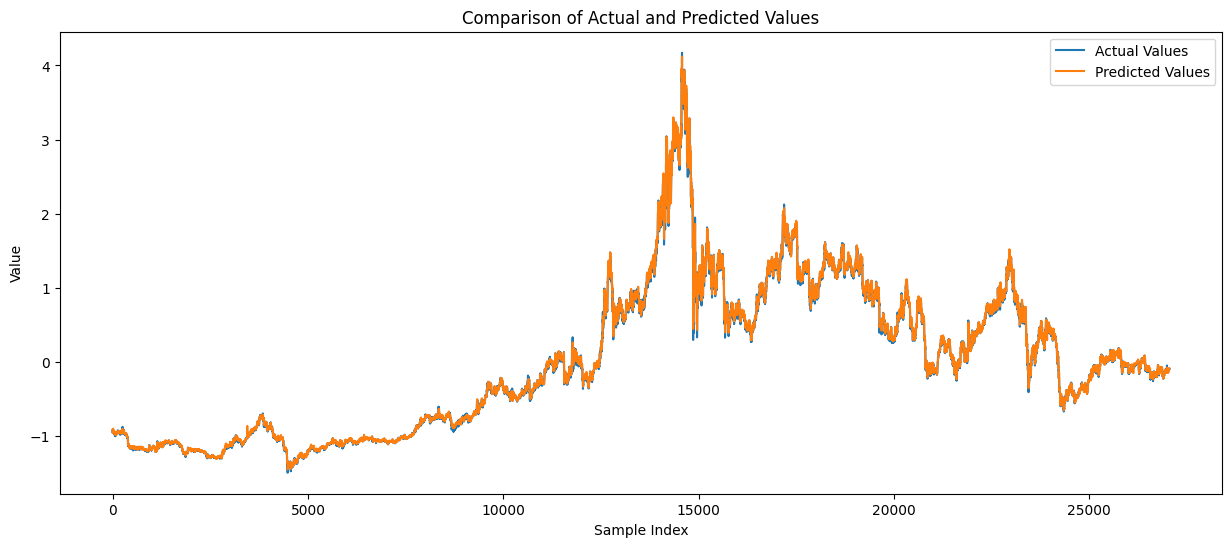

In [15]:
evaluate(model, X_train, y_train)

242/242 [==============================] - 0s 442us/step


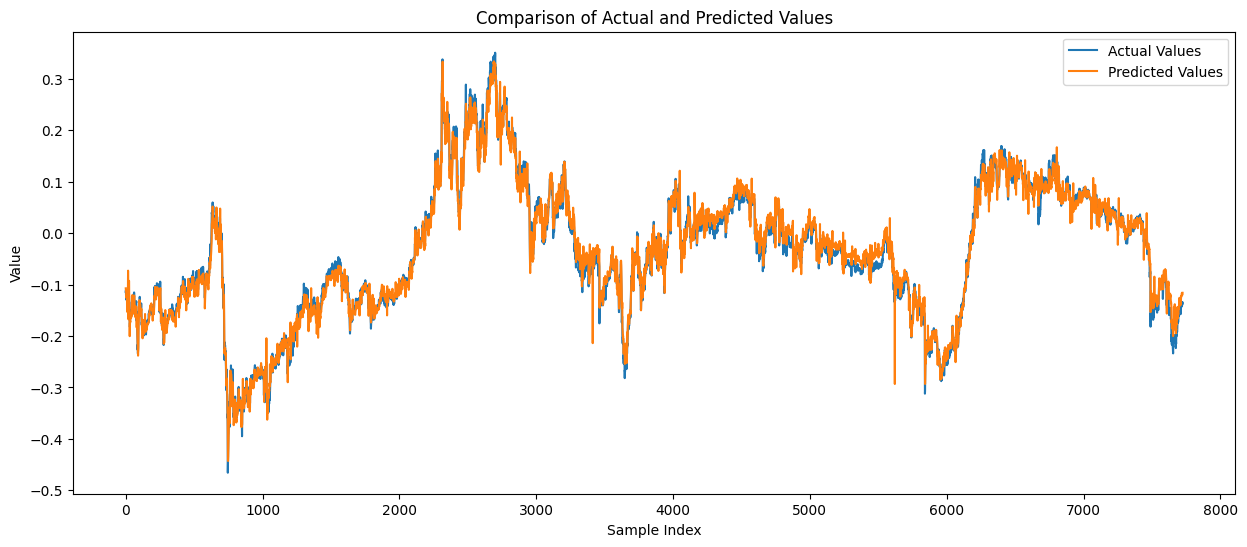

In [16]:
evaluate(model, X_val, y_val)

121/121 [==============================] - 0s 465us/step


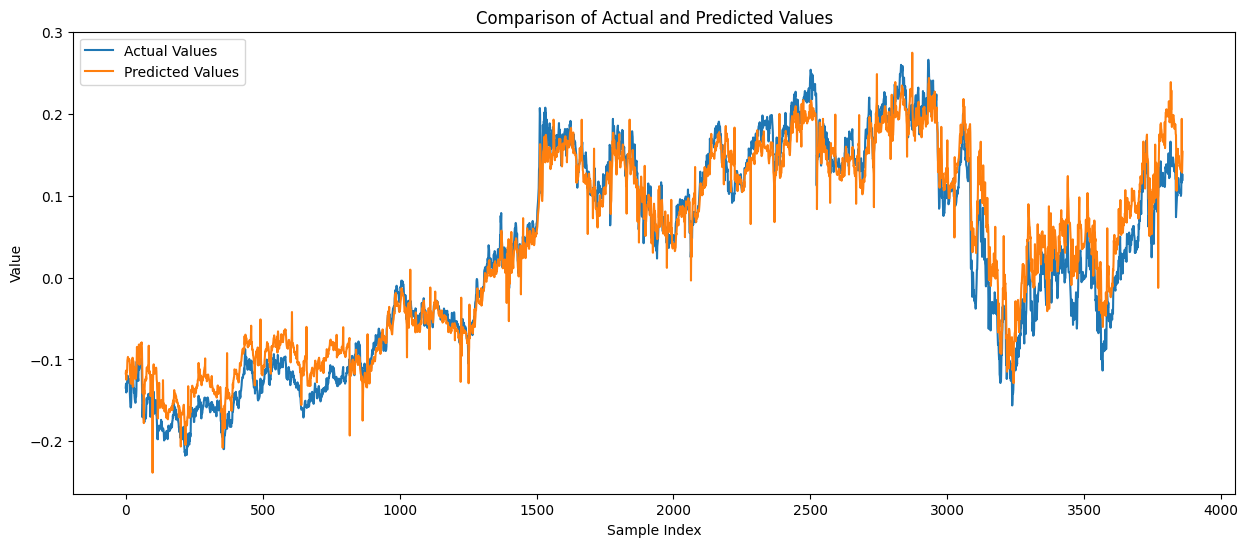

In [17]:
evaluate(model, X_test, y_test)

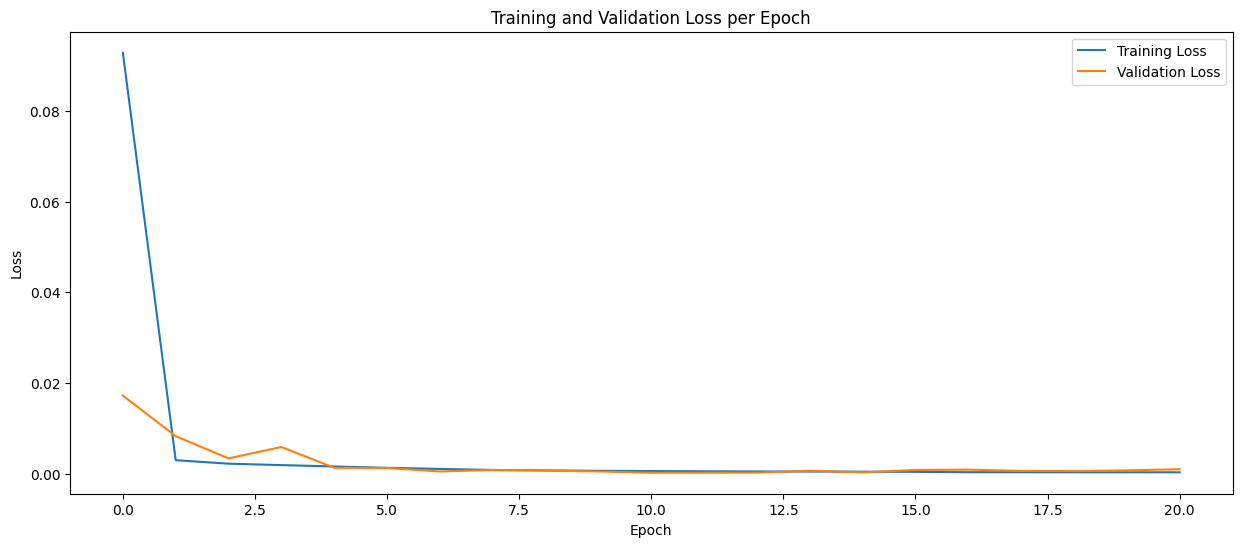

In [18]:
import matplotlib.pyplot as plt

# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()